In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedKFold, StratifiedShuffleSplit,
    cross_val_predict, RandomizedSearchCV
)
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, balanced_accuracy_score, f1_score
)
from sklearn.multioutput import MultiOutputClassifier
!pip install catboost
from catboost import CatBoostClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
USE_GPU = True  # << set False to force CPU
SUBSET_FRACTION = 0.30  # fraction of rows used for hyperparam search
N_FOLDS_OOF = 5         # for OOF evaluation
CV_TUNE = 3             # folds for tuning (faster)
N_ITER_TUNE = 16        # trials in RandomizedSearch (faster)

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train_test_data/train_encoded.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/train_test_data/test_encoded.csv")

In [ ]:
TARGETS = ["Genetic Disorder", "Disorder Subclass"]

In [ ]:
X_train = train_df.drop(columns=TARGETS)
Y_train = train_df[TARGETS].copy()
X_test  = test_df.copy()

In [ ]:
numeric_cols = X_train.select_dtypes(
    include=["int64", "float64", "int32", "float32"]
).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_cols)],
    remainder="passthrough"
)

In [ ]:
def make_catboost_base():
    common = dict(
        loss_function="MultiClass",
        eval_metric="TotalF1",     # macro-like F1 across classes
        random_seed=RANDOM_STATE,
        verbose=100,               # << verbose enabled (frequency)
        allow_writing_files=False, # cleaner runs in Colab
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3.0,
        iterations=800,
        border_count=128
    )
    if USE_GPU:
        return CatBoostClassifier(
            task_type="GPU",
            devices="0",
            **common
        )
    else:
        return CatBoostClassifier(
            thread_count=-1,
            **common
        )

In [ ]:
base_cat = make_catboost_base()

In [ ]:
cv_oof = StratifiedKFold(n_splits=N_FOLDS_OOF, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
def evaluate_target(target_name: str):
    y = Y_train[target_name]
    pipe = Pipeline([("prep", preprocessor), ("clf", base_cat)])

    # OOF predictions & probabilities
    print(f"\n[OOF] Starting {N_FOLDS_OOF}-fold CV for target: {target_name} ...")
    y_pred_oof  = cross_val_predict(pipe, X_train, y, cv=cv_oof, method="predict", n_jobs=-1, verbose=1)
    y_proba_oof = cross_val_predict(pipe, X_train, y, cv=cv_oof, method="predict_proba", n_jobs=-1, verbose=1)

    # Flatten CatBoost's (n,1) -> (n,)
    if hasattr(y_pred_oof, "ndim") and y_pred_oof.ndim > 1:
        y_pred_oof = y_pred_oof.ravel()

    # --- Text metrics
    print(f"\n=== {target_name} — OOF Classification Report ({N_FOLDS_OOF}-fold CV, CatBoost) ===\n")
    print(classification_report(y, y_pred_oof, digits=4, zero_division=0))

    # --- Confusion Matrix
    classes = np.unique(np.concatenate([np.asarray(y), np.asarray(y_pred_oof)]))
    cm = confusion_matrix(y, y_pred_oof, labels=classes)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes),
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")
    ax.set_title(f"Confusion Matrix — {target_name} (OOF, CatBoost)")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

    # --- ROC (OvR) from OOF probabilities
    if y_proba_oof is not None and y_proba_oof.ndim == 2 and y_proba_oof.shape[1] >= 2:
        # Fit once to get class order (legend only)
        pipe.fit(X_train, y)
        cls_order = pipe.named_steps["clf"].classes_

        fig = plt.figure(figsize=(7, 5))
        for k, cls in enumerate(cls_order):
            fpr, tpr, _ = roc_curve((y == cls).astype(int), y_proba_oof[:, k])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, linewidth=2, label=f"{cls} (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves (OvR) — {target_name} (OOF, CatBoost)")
        plt.legend()
        plt.show()


[OOF] Starting 5-fold CV for target: Genetic Disorder ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.2s finished



=== Genetic Disorder — OOF Classification Report (5-fold CV, CatBoost) ===

              precision    recall  f1-score   support

           0     0.6580    0.7858    0.7162      9241
           1     0.4635    0.3346    0.3886      1877
           2     0.5685    0.4640    0.5110      6929

    accuracy                         0.6153     18047
   macro avg     0.5633    0.5281    0.5386     18047
weighted avg     0.6034    0.6153    0.6034     18047



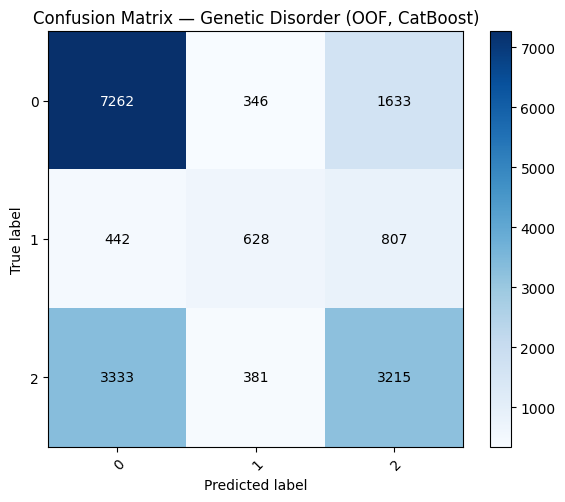

0:	learn: 0.5835907	total: 59.8ms	remaining: 47.8s
100:	learn: 0.6218469	total: 1.87s	remaining: 12.9s
200:	learn: 0.6402796	total: 4.24s	remaining: 12.6s
300:	learn: 0.6592056	total: 5.05s	remaining: 8.38s
400:	learn: 0.6761258	total: 5.73s	remaining: 5.7s
500:	learn: 0.6943059	total: 6.41s	remaining: 3.83s
600:	learn: 0.7109243	total: 7.04s	remaining: 2.33s
700:	learn: 0.7267434	total: 7.69s	remaining: 1.09s
799:	learn: 0.7401145	total: 8.31s	remaining: 0us


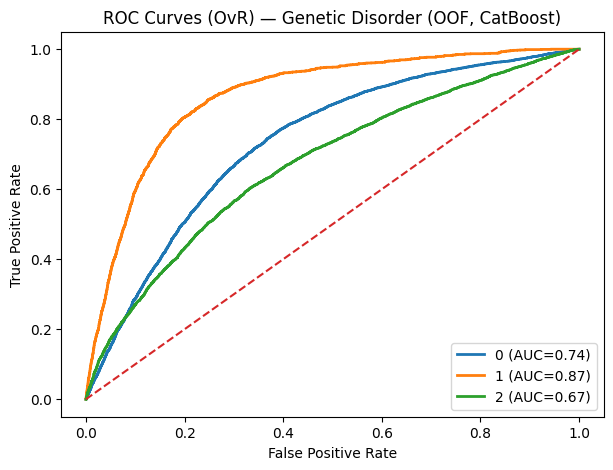


[OOF] Starting 5-fold CV for target: Disorder Subclass ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished



=== Disorder Subclass — OOF Classification Report (5-fold CV, CatBoost) ===

              precision    recall  f1-score   support

           0     0.3939    0.0977    0.1566       133
           1     0.3571    0.0549    0.0952        91
           2     0.4750    0.5418    0.5062      3145
           3     0.4119    0.2674    0.3243      1653
           4     0.4053    0.2980    0.3435      1228
           5     0.3646    0.1721    0.2338       587
           6     0.4389    0.5328    0.4813      4683
           7     0.3640    0.3702    0.3670      3971
           8     0.3407    0.3247    0.3325      2556

    accuracy                         0.4115     18047
   macro avg     0.3946    0.2955    0.3156     18047
weighted avg     0.4069    0.4115    0.4033     18047



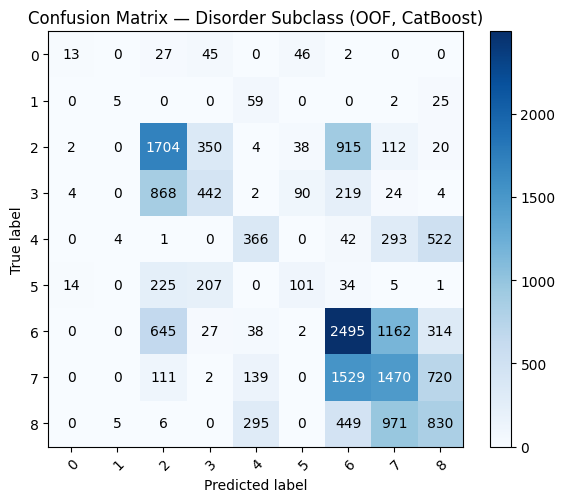

0:	learn: 0.3710803	total: 12.6ms	remaining: 10s
100:	learn: 0.4440530	total: 868ms	remaining: 6.01s
200:	learn: 0.4935406	total: 1.65s	remaining: 4.92s
300:	learn: 0.5335952	total: 2.46s	remaining: 4.08s
400:	learn: 0.5717370	total: 3.29s	remaining: 3.28s
500:	learn: 0.6031206	total: 4.33s	remaining: 2.59s
600:	learn: 0.6337065	total: 7.96s	remaining: 2.64s
700:	learn: 0.6621899	total: 11.1s	remaining: 1.56s
799:	learn: 0.6904574	total: 11.9s	remaining: 0us


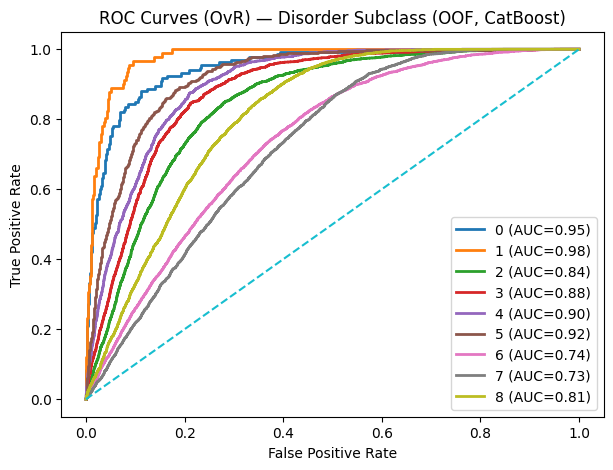

In [ ]:
for tgt in TARGETS:
    evaluate_target(tgt)

In [ ]:
per_target_rows = []
for tgt in TARGETS:
    y = Y_train[tgt]
    pipe = Pipeline([("prep", preprocessor), ("clf", base_cat)])
    print(f"\n[OOF] Computing summary metrics for {tgt} ...")
    y_pred_oof = cross_val_predict(pipe, X_train, y, cv=cv_oof, method="predict", n_jobs=-1, verbose=1)

    acc  = accuracy_score(y, y_pred_oof)
    bacc = balanced_accuracy_score(y, y_pred_oof)
    f1m  = f1_score(y, y_pred_oof, average="macro", zero_division=0)
    f1w  = f1_score(y, y_pred_oof, average="weighted", zero_division=0)
    per_target_rows.append({"target": tgt, "accuracy": acc, "balanced_accuracy": bacc, "f1_macro": f1m, "f1_weighted": f1w})


[OOF] Computing summary metrics for Genetic Disorder ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



[OOF] Computing summary metrics for Disorder Subclass ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [ ]:
summary_df = pd.DataFrame(per_target_rows).round(4)
print("\nOOF summary per target (CatBoost base):")
print(summary_df.to_string(index=False))


OOF summary per target (CatBoost base):
           target  accuracy  balanced_accuracy  f1_macro  f1_weighted
 Genetic Disorder    0.6153             0.5281    0.5386       0.6034
Disorder Subclass    0.4115             0.2955    0.3156       0.4033


In [ ]:
mean_acc = float(np.mean(summary_df["accuracy"]))
print("\nOverall mean accuracy (OOF across targets): {:.4f}".format(mean_acc))


Overall mean accuracy (OOF across targets): 0.5134


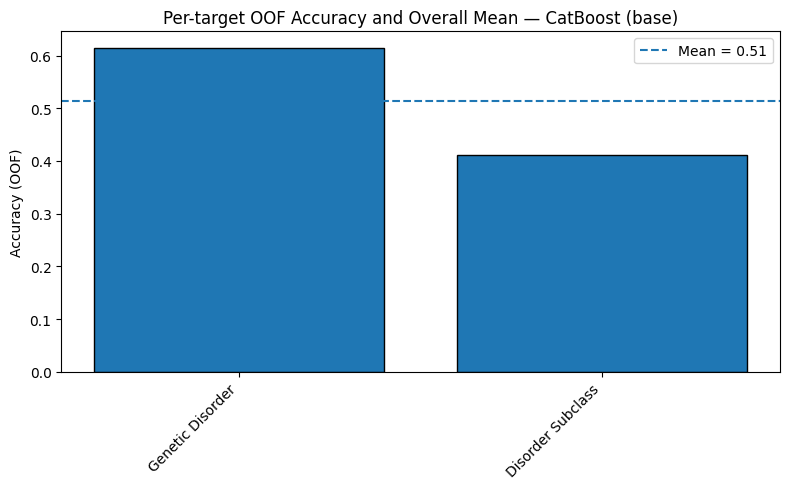

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(summary_df["target"], summary_df["accuracy"], edgecolor="black")
plt.axhline(mean_acc, linestyle="--", label=f"Mean = {mean_acc:.2f}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (OOF)")
plt.title("Per-target OOF Accuracy and Overall Mean — CatBoost (base)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_primary = Y_train["Genetic Disorder"]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=SUBSET_FRACTION, random_state=RANDOM_STATE)
sub_ix, _ = next(sss.split(X_train, y_primary))
X_tune, y_tune = X_train.iloc[sub_ix], y_primary.iloc[sub_ix]

In [ ]:
def make_catboost_tune():
    # lighter base; params will be overridden by RandomizedSearchCV
    common = dict(
        loss_function="MultiClass",
        eval_metric="TotalF1",
        random_seed=RANDOM_STATE,
        verbose=100,
        allow_writing_files=False
    )
    if USE_GPU:
        return CatBoostClassifier(task_type="GPU", devices="0", **common)
    else:
        return CatBoostClassifier(thread_count=-1, **common)

pipe_gs = Pipeline([
    ("prep", preprocessor),
    ("clf", make_catboost_tune())
])

In [ ]:
param_dist = {
    # trees/learning/structure
    "clf__iterations":        [400, 600, 800, 1000],
    "clf__depth":             [4, 6, 8],
    "clf__learning_rate":     [0.03, 0.05, 0.1],
    # regularization & randomness
    "clf__l2_leaf_reg":       [1.0, 3.0, 5.0, 7.0],
    "clf__random_strength":   [0.5, 1.0, 2.0],
    "clf__bagging_temperature":[0.0, 0.5, 1.0],
    # borders (affects speed/accuracy tradeoff)
    "clf__border_count":      [64, 128, 254],
}

In [ ]:
print(f"\n[FAST TUNING] RandomizedSearchCV on subset ({len(X_tune)} rows), "
      f"n_iter={N_ITER_TUNE}, cv={CV_TUNE}, verbose=2 ...")


[FAST TUNING] RandomizedSearchCV on subset (12632 rows), n_iter=16, cv=3, verbose=2 ...


In [ ]:
fast_gs = RandomizedSearchCV(
    estimator=pipe_gs,
    param_distributions=param_dist,
    n_iter=N_ITER_TUNE,
    scoring="f1_macro",
    cv=CV_TUNE,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2,     # << verbose enabled
    refit=True
)

In [ ]:
fast_gs.fit(X_tune, y_tune)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
0:	learn: 0.5951433	total: 45.7ms	remaining: 27.4s
100:	learn: 0.6386283	total: 1.36s	remaining: 6.72s
200:	learn: 0.6762146	total: 2.48s	remaining: 4.92s
300:	learn: 0.7084344	total: 3.59s	remaining: 3.57s
400:	learn: 0.7403326	total: 4.74s	remaining: 2.35s
500:	learn: 0.7666659	total: 6.45s	remaining: 1.27s
599:	learn: 0.7925815	total: 9.74s	remaining: 0us


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Gender_ambiguous',
                                                                                'Gender_female',
                                                                                'Gender_male',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_abnormal',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_inconclusive',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_normal',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_slightly '
                                                                                'abnormal',
                                                                                'Patient '
                                                                                'Age',
                                                                                'Blood '
                                                                                'cel...
                                              <catboost.core.CatBoostClassifier object at 0x7e40cdad6360>)]),
                   n_iter=16, n_jobs=-1,
                   param_distributions={'clf__bagging_temperature': [0.0, 0.5,
                                                                     1.0],
                                        'clf__border_count': [64, 128, 254],
                                        'clf__depth': [4, 6, 8],
                                        'clf__iterations': [400, 600, 800,
                                                            1000],
                                        'clf__l2_leaf_reg': [1.0, 3.0, 5.0,
                                                             7.0],
                                        'clf__learning_rate': [0.03, 0.05, 0.1],
                                        'clf__random_strength': [0.5, 1.0,
                                                                 2.0]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [ ]:
print("\nFAST best params:", fast_gs.best_params_)
print("FAST best CV macro-F1:", round(fast_gs.best_score_, 4))


FAST best params: {'clf__random_strength': 0.5, 'clf__learning_rate': 0.03, 'clf__l2_leaf_reg': 5.0, 'clf__iterations': 600, 'clf__depth': 8, 'clf__border_count': 64, 'clf__bagging_temperature': 0.5}
FAST best CV macro-F1: 0.5284


In [ ]:
best = fast_gs.best_params_

In [ ]:
def make_catboost_best(best_params):
    return CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="TotalF1",
        iterations=best_params["clf__iterations"],
        depth=best_params["clf__depth"],
        learning_rate=best_params["clf__learning_rate"],
        l2_leaf_reg=best_params["clf__l2_leaf_reg"],
        random_strength=best_params["clf__random_strength"],
        bagging_temperature=best_params["clf__bagging_temperature"],
        border_count=best_params["clf__border_count"],
        random_seed=RANDOM_STATE,
        verbose=100,
        allow_writing_files=False,
        task_type="GPU", devices="0"
    ) if USE_GPU else CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="TotalF1",
        iterations=best_params["clf__iterations"],
        depth=best_params["clf__depth"],
        learning_rate=best_params["clf__learning_rate"],
        l2_leaf_reg=best_params["clf__l2_leaf_reg"],
        random_strength=best_params["clf__random_strength"],
        bagging_temperature=best_params["clf__bagging_temperature"],
        border_count=best_params["clf__border_count"],
        random_seed=RANDOM_STATE,
        verbose=100,
        allow_writing_files=False,
        thread_count=-1
    )

In [ ]:
best_cat = make_catboost_best(best)

In [ ]:
print("\n[FINAL FIT] Fitting MultiOutputClassifier with tuned CatBoost on ALL training data ...")
X_train_t = preprocessor.fit_transform(X_train)


[FINAL FIT] Fitting MultiOutputClassifier with tuned CatBoost on ALL training data ...


In [ ]:
multi_cat = MultiOutputClassifier(best_cat)
multi_cat.fit(X_train_t, Y_train)

0:	learn: 0.5979415	total: 40.3ms	remaining: 24.2s
100:	learn: 0.6312047	total: 5.18s	remaining: 25.6s
200:	learn: 0.6577400	total: 6.37s	remaining: 12.7s
300:	learn: 0.6826150	total: 7.51s	remaining: 7.46s
400:	learn: 0.7067156	total: 8.64s	remaining: 4.29s
500:	learn: 0.7315862	total: 9.77s	remaining: 1.93s
599:	learn: 0.7546702	total: 10.9s	remaining: 0us
0:	learn: 0.3919842	total: 16.2ms	remaining: 9.69s
100:	learn: 0.4463488	total: 1.56s	remaining: 7.73s
200:	learn: 0.5121953	total: 3.28s	remaining: 6.52s
300:	learn: 0.5680000	total: 7.31s	remaining: 7.26s
400:	learn: 0.6141575	total: 9.09s	remaining: 4.51s
500:	learn: 0.6549262	total: 10.8s	remaining: 2.13s
599:	learn: 0.6913672	total: 12.4s	remaining: 0us


MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7e40cefa85c0>)

In [ ]:
X_test_t = preprocessor.transform(X_test)

In [ ]:
Y_test_pred = multi_cat.predict(X_test_t)           # shape: (n_test, len(TARGETS))
proba_list  = multi_cat.predict_proba(X_test_t)

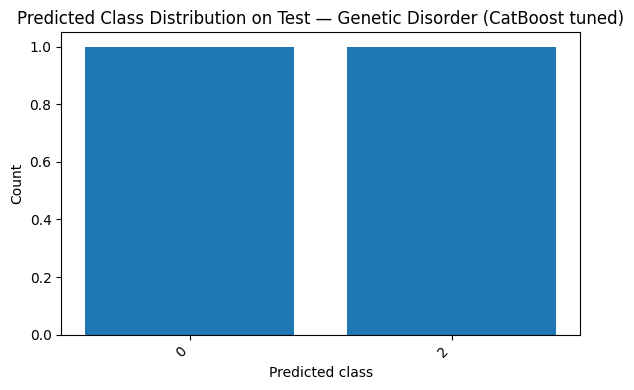

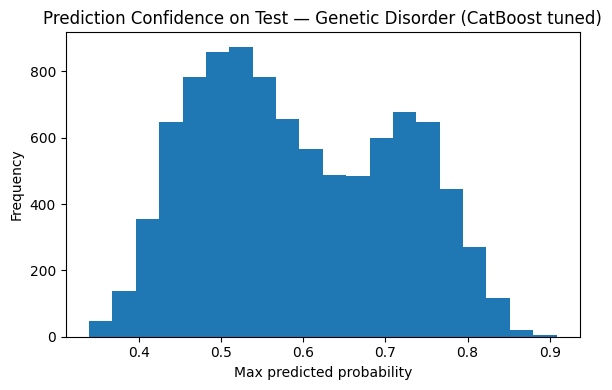

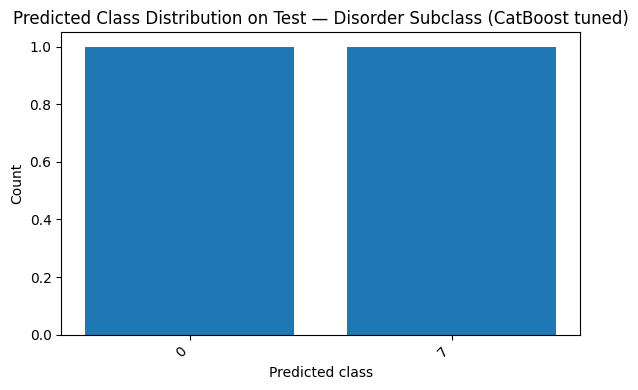

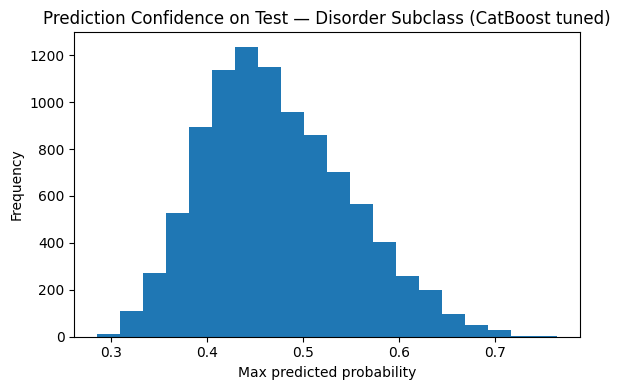

In [ ]:
for t, target in enumerate(TARGETS):
    y_pred_t = Y_test_pred[:, t].astype(str)

    # (a) Predicted class distribution
    fig = plt.figure(figsize=(6, 4))
    uniq, cnts = np.unique(y_pred_t, return_counts=True)
    order = np.argsort(uniq.astype(str))
    uniq, cnts = uniq[order], cnts[order]
    plt.bar(uniq.astype(str), cnts)
    plt.xlabel("Predicted class")
    plt.ylabel("Count")
    plt.title(f"Predicted Class Distribution on Test — {target} (CatBoost tuned)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # (b) Confidence histogram (max probability)
    if proba_list is not None and len(proba_list) > t and proba_list[t] is not None:
        max_conf = proba_list[t].max(axis=1)
        fig = plt.figure(figsize=(6, 4))
        plt.hist(max_conf, bins=20)
        plt.xlabel("Max predicted probability")
        plt.ylabel("Frequency")
        plt.title(f"Prediction Confidence on Test — {target} (CatBoost tuned)")
        plt.tight_layout()
        plt.show()

In [ ]:
RAW_FEATURES = [
    "Gender_ambiguous","Gender_female","Gender_male",
    "Blood test result_abnormal","Blood test result_inconclusive","Blood test result_normal","Blood test result_slightly abnormal",
    "Patient Age","Blood cell count (mcL)","Mother's age","Father's age",
    "Test 1","Test 2","Test 3","Test 4","Test 5",
    "No. of previous abortion",
    "White Blood cell count (thousand per microliter)",
    "Symptom 1","Symptom 2","Symptom 3","Symptom 4","Symptom 5",
    "Parental Age Diff","Symptom Score",
    "Genes in mother's side","Inherited from father","Maternal gene","Paternal gene",
    "Status","Respiratory Rate (breaths/min)","Heart Rate (rates/min",  # NOTE: no closing ')'
    "Follow-up","Birth asphyxia","Autopsy shows birth defect (if applicable)",
    "Folic acid details (peri-conceptional)",
    "H/O serious maternal illness","H/O radiation exposure (x-ray)",
    "H/O substance abuse","Assisted conception IVF/ART",
    "History of anomalies in previous pregnancies","Birth defects"
]

In [ ]:
TARGETS = ["Genetic Disorder", "Disorder Subclass"]

DISORDER_NAMES = [
    "Mitochondrial genetic inheritance disorders",   # 0
    "Multifactorial genetic inheritance disorders",  # 1
    "Single-gene inheritance diseases"               # 2
]

SUBCLASS_NAMES = [
    "Cancer","Cystic fibrosis","Diabetes","Down syndrome","Huntington's disease",
    "Klinefelter syndrome","Leber's hereditary optic neuropathy","Leigh syndrome","Turner syndrome"
]

NAME_CATALOG = {
    "Genetic Disorder": DISORDER_NAMES,
    "Disorder Subclass": SUBCLASS_NAMES
}

In [ ]:
# =========================
# FINAL PIPELINE & EXPORT
# =========================
import os, json, time, platform, joblib, zipfile, shutil
import numpy as np
import pandas as pd
from pathlib import Path
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier

# 3.1 Make a fresh CatBoost with your tuned params (from `best`)
def make_catboost_from_best(best_params, use_gpu=True):
    base = dict(
        loss_function="MultiClass",
        eval_metric="TotalF1",
        iterations=best_params["clf__iterations"],
        depth=best_params["clf__depth"],
        learning_rate=best_params["clf__learning_rate"],
        l2_leaf_reg=best_params["clf__l2_leaf_reg"],
        random_strength=best_params["clf__random_strength"],
        bagging_temperature=best_params["clf__bagging_temperature"],
        border_count=best_params["clf__border_count"],
        random_seed=42,
        verbose=100,
        allow_writing_files=False
    )
    if use_gpu:
        return CatBoostClassifier(task_type="GPU", devices="0", **base)
    return CatBoostClassifier(thread_count=-1, **base)

best_cat_for_pipe = make_catboost_from_best(best, use_gpu=USE_GPU)

# 3.2 Build the single pipeline that your API expects: raw df → preprocessor → MultiOutput(CatBoost)
full_pipe = Pipeline([
    ("prep", preprocessor),                    # use your existing ColumnTransformer
    ("clf",  MultiOutputClassifier(best_cat_for_pipe))
])

# 3.3 Fit on ALL training data with raw columns (NO manual transform here)
#     Ensure X_train has the RAW_FEATURES columns in any order (Pipeline aligns by name).
assert set(RAW_FEATURES).issubset(set(X_train.columns)), "X_train must have all 42 raw feature columns."
full_pipe.fit(X_train[RAW_FEATURES], Y_train[TARGETS])

# 3.4 Verify it predicts from a 1-row DataFrame with the 42 keys
probe = pd.DataFrame([{k: 0.0 for k in RAW_FEATURES}])
_ = full_pipe.predict(probe)   # should not error

# 3.5 Prepare output dir
task_name = "genetic_disorder"
version   = time.strftime("v%Y-%m-%d_%H-%M")
root      = Path("/content/model_bundles")
out_dir   = root / task_name / version
out_dir.mkdir(parents=True, exist_ok=True)

# 3.6 Save pipeline
joblib.dump(full_pipe, out_dir / "pipeline.joblib", compress=3)

# 3.7 schema.json (feature order + dtype)
schema = {
    "features": [{"name": k, "dtype": "float64", "allow_null": False} for k in RAW_FEATURES],
    "required": RAW_FEATURES
}
(out_dir / "schema.json").write_text(json.dumps(schema, indent=2), encoding="utf-8")

# 3.8 targets.json — human class names in estimator order
def _to_int_like(x):
    if isinstance(x, (np.integer, int)): return int(x)
    if isinstance(x, str) and x.isdigit(): return int(x)
    raise ValueError(f"Estimator class '{x}' not int-like; adjust mapping.")

human_classes = {}
raw_classes   = {}
# Access underlying estimators via full_pipe.named_steps["clf"].estimators_
estimators = full_pipe.named_steps["clf"].estimators_
for i, target in enumerate(TARGETS):
    est = estimators[i]
    raw = list(est.classes_)
    raw_classes[target] = [str(x) for x in raw]
    names_catalog = NAME_CATALOG[target]
    ordered_names = []
    for x in raw:
        idx = _to_int_like(x)
        try:
            ordered_names.append(names_catalog[idx])
        except IndexError:
            raise IndexError(f"[{target}] class index {idx} not found in NAME_CATALOG.")
    human_classes[target] = ordered_names

targets_payload = {
    "targets": TARGETS,
    "classes": human_classes,
    "raw_estimator_classes": raw_classes  # optional for audit
}
(out_dir / "targets.json").write_text(json.dumps(targets_payload, indent=2), encoding="utf-8")

# 3.9 metrics.json (if you computed summary_df earlier, plug actuals)
try:
    metrics = {
        "oof": {
            # Replace with your real numbers if available:
            # "Genetic Disorder": {"accuracy": float(summary_df.query("target=='Genetic Disorder'")["accuracy"].iloc[0])},
            # "Disorder Subclass": {"accuracy": float(summary_df.query("target=='Disorder Subclass'")["accuracy"].iloc[0])}
        },
        "notes": "Populate with notebook validation metrics (OOF) if desired."
    }
except Exception:
    metrics = {"oof": {}, "notes": "No metrics captured in this run."}
(out_dir / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")

# 3.10 model_info.yaml
try:
    import sklearn as sk
    skver = sk.__version__
except Exception:
    skver = "unknown"

model_info = f"""\
name: genetic_disorder_catboost
version: {version}
trained_at: {time.strftime("%Y-%m-%d %H:%M:%S")}
framework: sklearn+catboost
sklearn_version: {skver}
python_version: {platform.python_version()}
platform: {platform.platform()}
notes: "MultiOutput(CatBoostClassifier) with tuned params; pipeline includes preprocessing + model."
"""
(out_dir / "model_info.yaml").write_text(model_info, encoding="utf-8")

# 3.11 Zip + download
zip_path = root / f"{task_name}_{version}.zip"
if zip_path.exists(): zip_path.unlink()
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for p in out_dir.rglob("*"):
        z.write(p, p.relative_to(root))

print("Bundle at:", zip_path)
files.download(zip_path.as_posix())

0:	learn: 0.5979415	total: 18.4ms	remaining: 11s
100:	learn: 0.6312047	total: 1.21s	remaining: 5.98s
200:	learn: 0.6577400	total: 2.31s	remaining: 4.58s
300:	learn: 0.6826150	total: 3.41s	remaining: 3.39s
400:	learn: 0.7067156	total: 6.49s	remaining: 3.22s
500:	learn: 0.7315862	total: 8.6s	remaining: 1.7s
599:	learn: 0.7546702	total: 9.7s	remaining: 0us
0:	learn: 0.3919842	total: 15.6ms	remaining: 9.37s
100:	learn: 0.4463488	total: 1.52s	remaining: 7.5s
200:	learn: 0.5121953	total: 3.18s	remaining: 6.31s
300:	learn: 0.5680000	total: 4.87s	remaining: 4.84s
400:	learn: 0.6141575	total: 6.53s	remaining: 3.24s
500:	learn: 0.6549262	total: 8.99s	remaining: 1.78s
599:	learn: 0.6913672	total: 12.4s	remaining: 0us
Bundle at: /content/model_bundles/genetic_disorder_v2025-10-03_04-11.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>